In [166]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
print('Setup done')

Setup done


In [184]:
from google.colab import drive

drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [185]:
df = pd.read_csv('/content/gdrive/MyDrive/sar.csv', sep=',')
df_client_rfm = pd.read_csv('/content/gdrive/MyDrive/client_rfm.csv', sep=',')
print("dataset Loaded")

dataset Loaded


In [187]:
df_client_rfm = df_client_rfm[['Client','Rank_Recency','Rank_Frequency','Rank_Monetary','Cluster']]

In [23]:
# Download the actual data from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
# Use the ratings.csv file
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
ratings = pd.read_csv(ratings_file)
movies = pd.read_csv(movielens_dir / "movies.csv")

In [123]:
df['ProductId'].nunique()

54708

In [189]:
df_client_product = df[['Client','ProductId','Rating']].copy()
df_client_product = pd.merge(df_client_product,df_client_rfm,on='Client',how='left')

df_client_product.drop_duplicates(keep='first',inplace=True,subset=['Client','ProductId']) 


n_users = df_client_product['Client'].nunique()
n_users

10816

In [192]:
df_client_product

,Client,ProductId,Rating,Rank_Recency,Rank_Frequency,Rank_Monetary,Cluster
0,Barry Barrett,116945202798,7.5,1736,2000,2000,4
32,Penny Burns,106945202919,7.5,1170,2000,2000,4
64,Arthur Mason,64807203169,6.5,2001,2000,2000,4
96,Barry Barrett,166945203195,7.5,1736,2000,2000,4
128,Barry Barrett,96945202702,7.5,1736,2000,2000,4
...,...,...,...,...,...,...,...
1628892,Darin Todd,33569202865,4.5,1346,1562,1471,4
1628917,Kent Pittman,33569203104,6.0,1515,1762,1802,4
1628918,Leona Harrison,4807203450,6.0,1824,1940,1905,4
1628920,Angelo Wagner,354807203625,5.0,1535,1426,1139,4


In [145]:
df_product = df[['ProductId','Product','Product Category','Product Cost']].copy()
df_product.drop_duplicates(keep='first',inplace=True) 

n_prod = df_product['ProductId'].nunique()
n_prod

54708

In [146]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

prod_enc = LabelEncoder()
df_client_product['Client'] = prod_enc.fit_transform(df_client_product['Client'].values)

prod_enc = LabelEncoder()
df_product['Product'] = prod_enc.fit_transform(df_product['Product'].values)

prod_cat_enc = LabelEncoder()
df_product['Product Category'] = prod_cat_enc.fit_transform(df_product['Product Category'].values)

prod_id_enc = LabelEncoder()
df_product['ProductId'] = prod_id_enc.fit_transform(df_product['ProductId'].values)
df_client_product['ProductId'] = prod_id_enc.transform(df_client_product['ProductId'].values)

In [147]:
train, test = train_test_split(df_client_product, test_size=0.2, random_state=42)

In [173]:
from keras.layers import Input, Embedding, Flatten, Dot, Dense,Concatenate
from keras.models import Model

product_input = Input(shape=[2], name="Product-Input")

product_embedding = Embedding(n_prod+1, 5, name="Product-Embedding")(product_input)
product_vec = Flatten(name="Flatten-Product")(product_embedding)

user_input = Input(shape=[2], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)
# prod = Dot(name="Dot-Product", axes=1)([product_vec, user_vec])
concatted = Concatenate()([product_vec, user_vec])
d = Dense(4, kernel_initializer='normal')(concatted)
out = Dense(1, kernel_initializer='normal')(d)
model = Model([user_input, product_input], out)
model.compile('adam', 'mean_squared_error')

In [174]:
history = model.fit([train[['Client','Client']], train[['ProductId','ProductId']]], train['Rating'],validation_data=([test['Client'], test['ProductId']], test['Rating']), epochs=1, verbose=1)
model.save('regression_model.h5')

12575/12577 [============================>.] - ETA: 0s - loss: 3.2926WARNING:tensorflow:Model was constructed with shape (None, 2) for input KerasTensor(type_spec=TensorSpec(shape=(None, 2), dtype=tf.float32, name='User-Input'), name='User-Input', description="created by layer 'User-Input'"), but it was called on an input with incompatible shape (None, 1).


ValueError: ignored

In [43]:
df = df.drop(['Company Code','Order Number','Product Cost','Amount','Discount Amount','Client City','Total','Date','Rating_rf','Rating_Cust','Form of payment'],axis=1)

In [66]:
df_product

,ProductId,Product,Product Category,Product Cost
65504,1028714901,Additives And Fluids 2116,Additives And Fluids,4.935
92672,856702313963,Lubricant 403,Lubricant,14.986
122112,154842314889,Lubricant 1249,Lubricant,16.260
127744,114673194655,Flavoring 2582,Flavoring,4.689
132896,395622233968,Lubricant 3487,Lubricant,4.000
...,...,...,...,...
1628066,855982317279,Lubricant 3204,Lubricant,20.040
1628129,426391302668,Popsicle And Ice Creams 85,Popsicle And Ice Creams,2.700
1628472,64966224634,Juices And Soft Drinks 1089,Juices And Soft Drinks,4.668
1628748,435218222861,Juices And Soft Drinks 287,Juices And Soft Drinks,2.893


In [3]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)


Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


In [5]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)


In [6]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)


In [7]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)


Epoch 1/5
1418/1418 [==============================] - 8s 5ms/step - loss: 0.6591 - val_loss: 0.6208
Epoch 2/5
1418/1418 [==============================] - 7s 5ms/step - loss: 0.6159 - val_loss: 0.6190
Epoch 3/5
1418/1418 [==============================] - 7s 5ms/step - loss: 0.6094 - val_loss: 0.6143
Epoch 4/5
1418/1418 [==============================] - 7s 5ms/step - loss: 0.6071 - val_loss: 0.6134
Epoch 5/5
1418/1418 [==============================] - 8s 5ms/step - loss: 0.6087 - val_loss: 0.6122


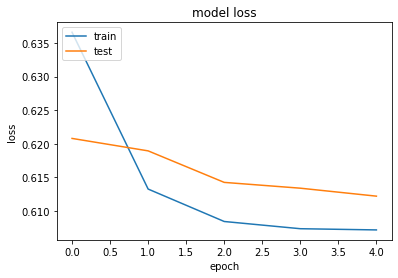

In [8]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()


In [9]:
movie_df = pd.read_csv(movielens_dir / "movies.csv")

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)


Showing recommendations for user: 43
Movies with high ratings from user
--------------------------------
Forrest Gump (1994) : Comedy|Drama|Romance|War
Jungle Book, The (1994) : Adventure|Children|Romance
Three Musketeers, The (1993) : Action|Adventure|Comedy|Romance
Pinocchio (1940) : Animation|Children|Fantasy|Musical
Children of the Corn IV: The Gathering (1996) : Horror
--------------------------------
Top 10 movie recommendations
--------------------------------
American History X (1998) : Crime|Drama
Fight Club (1999) : Action|Crime|Drama|Thriller
Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001) : Comedy|Romance
Lord of the Rings: The Fellowship of the Ring, The (2001) : Adventure|Fantasy
City of God (Cidade de Deus) (2002) : Action|Adventure|Crime|Drama|Thriller
Eternal Sunshine of the Spotless Mind (2004) : Drama|Romance|Sci-Fi
Departed, The (2006) : Crime|Drama|Thriller
Hot Fuzz (2007) : Action|Comedy|Crime|Mystery
Dark Knight, The (2008) : Action|Crime|Drama|IMAX
The Imit